# Chapter 7.3 -- Sampling the Tree

The tree can also be able to generate samples from it.
This is described in the second paper and the manual gives a small summary about it.

In this notebooks the basic usages are explained.
For this notebook the user must already knwon how to use conditions.

In [1]:
#
# L O A D I N G 
#
# The distributions are implemented in a sub module inside the pyYggdrasil module
import pyYggdrasil.Random as pyR

# We also need the normal part of pyYggdrasil
import pyYggdrasil as pyY

# We also need numpy 
import numpy as np

# We also need plotting
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


# Needed for the gauss kernel
from scipy import stats

In [2]:
# For that we also need an appropriate source of randomness.
geni = pyR.pRNG(42) 

# This is a large number, is used for fitting the tree
aLargeNumber = 1000000

## Making a Tree
In a first step we will use the canonical Gauss distribution of kind 2.
This is two dimensional distributions, with independent components.

$$
    \Sigma = \begin{pmatrix} 0 & 0 \\ 0 & 2 \end{pmatrix}
    %
    \qquad\qquad
    %
    \vec{\mu} = \begin{pmatrix} 1.4 \\ -4 \end{pmatrix}
$$

In [3]:
# generating the condition
gaussK2 = pyR.canDistribution(pyR.eDistiType.Gauss, 2)

print("The mean of the distribution")
print("   {}".format(gaussK2.getMean()))

print()
print("The covariance of the distribution")
print(gaussK2.getCoVar())

print()
print("The sampling domain is: {}".format(gaussK2.getSampleDomain()))

The mean of the distribution
   [ 1.4 -4. ]

The covariance of the distribution
[[2. 0.]
 [0. 2.]]

The sampling domain is: {[-10.000000, 10.000000[, [-10.000000, 10.000000[}


### Generating Samples
We will now generate the samples from the distribution.
This is done to fit the tree.

We see below that we have a bit of correlation, between the components, but it is not that large.
However we see that the statistics is quite accurate.

In [4]:
#
# Generate a large ammound of samples
sampleForFitting_gaussK2 = gaussK2.generateSamplesCollection(geni, aLargeNumber)

In [5]:
#
# We will now show the statistics of the generated samples
statFittingSamples_gaussK2 = pyR.estMeanCovar(sampleForFitting_gaussK2)

In [6]:
print("The empirical mean is")
print("   {}".format(statFittingSamples_gaussK2[0]))

print()
print("The empirical covariance is")
print(statFittingSamples_gaussK2[1])

The empirical mean is
   [ 1.39980917 -3.99959345]

The empirical covariance is
[[ 2.00146091 -0.00227021]
 [-0.00227021  1.99910426]]


### Fitting the Tree
Now we fit a tree we will use the following builder.

In [7]:
#
# Builder
builder = pyY.TreeBuilder(pyY.eParModel.LinModel
                ).setGOFLevel(0.001
                ).setIndepLevel(0.001
                ).useMedianSplitter()

In [8]:
#
# Fitting the tree
tree_gaussK2 = pyY.DETree(sampleForFitting_gaussK2, gaussK2.getSampleDomain(), builder)

In [9]:
# 
# Get some information about the tree
tree_gaussK2_comp = tree_gaussK2.getTreeComposition()

print("The tree has {} many leafs.".format(tree_gaussK2_comp[2]))

The tree has 433 many leafs.


## Unconditional Sampling
In a first step we will do unconditional sampling.

### Creating a Tree Sampler
We will need to create a tree sampler.
This si simply done by constructing one, not that the sampler lives in the Random submodule.
Since we do not want to apply conditions, we do not need to have any other conditions.

Note that the TreeSampler copies the part he needes from the tree.
Thus the tree is not needed any longer.
Since this is Python we _hope_ that the garbage collector will collect the tree if not needed any longer.
In C++ we would simply fo it ourself.

In [10]:
treeSampler_gaussK2 = pyY.Random.TreeSampler(tree_gaussK2)

In [11]:
#
# The sampler copies the leafs, or parts of them, to itself.
# The number of copied leafs can be accessed by
print("The unconditioned tree sampler has {} many leafs copied.".format(treeSampler_gaussK2.nProxy()))

if(treeSampler_gaussK2.nProxy() == tree_gaussK2_comp[2]):
    print("Since we do not apply any conditions all leafs are copied.")
else:
    raise ValueError("The number of nodes in the tree and the sampler are not the same.")

The unconditioned tree sampler has 433 many leafs copied.
Since we do not apply any conditions all leafs are copied.


### Using the Sampler
Now we will use the sampler.
For that we will generate a lot of samples from it and then compute the statistics of them.
They should be roughly the same as they where for the samples.

The sampler supports a _similar_ set of functions as the distributions does.
The main difference is that the sampler does not support a ``pdf(s)`` function.
This means it is not possible, it is possible, but it is realy inefficient, to calculate the probability of a sample.

However the probability of samples that are generated can be computed, since they are a by product of the sampling process.
For that use the the sufix ``PDF`` of the sampling functions.

In [12]:
#
# Now we generate samples that are drawn from the tree.
# Note that the probability is not calculated by this
gaussK2_bootSamples = treeSampler_gaussK2.generateSamplesCollection(geni, aLargeNumber * 10)

In [13]:
#
# This class will also generate the pdfs of the samples that where generated.
# They are stored in an NumPy compadible type.
#
# NOTE: This function returns a pair, that we unpack on the fly
gaussK2_bootSamples_, gaussK2_bootSamples_pdfs = treeSampler_gaussK2.generateSamplesCollectionPDF(geni, 10)

#### Verifing the Samples
We will now test if teh samples are such as we have expected them.
For this we will compute the statistics of them.

In [14]:
#
# Computing the statistics
statBootSamples_gaussK2 = pyR.estMeanCovar(gaussK2_bootSamples)


In [15]:
print("The empirical mean of the bootstraped samples is")
print("   {}".format(statBootSamples_gaussK2[0]))

print()
print("The empirical covariance of the bootstraped samples is")
print(statBootSamples_gaussK2[1])

The empirical mean of the bootstraped samples is
   [ 1.39984472 -3.99970675]

The empirical covariance of the bootstraped samples is
[[ 2.00661882 -0.00200724]
 [-0.00200724  2.00445943]]


In [16]:
#
# We now caluclate the relative error between the two covariance matriox
# Note we do not use the theoretical distribution, but the sample distribution from the 
# samples used for fitting.
gaussK2_relError = np.linalg.norm(
                        statFittingSamples_gaussK2[1] - statBootSamples_gaussK2[1]
                                    ) / (
                        np.linalg.norm(statFittingSamples_gaussK2[1]))

print("The relative error between the two covariances is {}.".format(gaussK2_relError))

The relative error between the two covariances is 0.0026316453462558397.


## Conditional Sampling
Here we will use a condition.
We will restrict the first dimension to $1.4$, which is also the mean.
Since the distribution is rather simple, the new covariance is given by
$$
    \Sigma = \begin{pmatrix} 0 & 0 \\ 0 & 2 \end{pmatrix}
$$

Note that in earlier versions the functions that returns sampels and pdf returned a quite interesting pdf.
This pdf was always unconditioned.
This was changed in a later iteration.
However it could be the case that some parts of the documentation and especialy this notebook was forgotten to be updated.
However this information is old.
And the pdf value that is now computed is the one the user would expect.

### Creating a Condition
First of all we must create a condition.
This was already explained in chaptor 1.1.

In [17]:
#
# This is the restriction, again use zero based indexing
gaussK2_condFirstDim = pyR.MultiCondition(2, [pyR.SingleCondition(0, 1.4)])

print("The condition is: {}".format(gaussK2_condFirstDim))

The condition is: {(0: 1.400000) | 2}


### Create a Sampler
Here we create a sampler.
This time we must pass the restriction to it.

The sampler supports similar functions as the condition does.

In [18]:
treeSampler_gaussK2_condFirstDim = pyR.TreeSampler(tree_gaussK2, gaussK2_condFirstDim)

#### Selected Leafs
In the unconditioned case we have seen that all the leafs were selected.
Hower this time this si rather unlikely, I mean it could happen, but is realy unlikely.

In [19]:
print("The conditioned sampler has selected {} many leafs.".format(treeSampler_gaussK2_condFirstDim.nProxy()))

The conditioned sampler has selected 28 many leafs.


#### Over Constrained Sampler
The sampler allows to be over constrained.
An over constarint sampler that is not able to meet the contraints.
For example that contrains are not part of the data domain of the tree.

It is important that no error is generated.
Hower no sample can be generated from it.

In [20]:
#
# This is our sampler that can be sampled from.
# To test if a sampler can be used to sample from the following function can be used
if(treeSampler_gaussK2_condFirstDim.notOverConstrained() == True):
    print("The sampler can be used, because it is not over contrained.")
else:
    raise ValueError("The sampler that should be able to sample, is over constrained.")

The sampler can be used, because it is not over contrained.


In [21]:
#
# We will now construct a sampler that is over contrained.
# Because the first component must have a value of 20, but the domain is only extended up to 10.

# This is an alternative constructor.
# The sampler integrates the constructor of the constratints.
# Instead of teh dimension of the sampleing space the tree must be passed.
overConstrainedSampler = pyR.TreeSampler(tree_gaussK2, [pyR.SingleCondition(0, 20.0)])

In [22]:
#
# Now we test if the sampler can be used
if(overConstrainedSampler.notOverConstrained() == False):
    print("The sampler can not be used, since it is over constrained.")
else:
    raise ValueError("The sampler does not appear to be over constarined, this is an serious error.")

The sampler can not be used, since it is over constrained.


### Test the Sampler
Now we will test how good the sampler has performed.
For that we will again use it for the generation of several samples and then we will anayse how well the statistic is.

In [23]:
#
# We will now generate the samples
# This will generate a sample array It will also calculate the probability of the samples.
#
condSampleBoot_gaussK2, condSampleBoot_gaussK2_pdf = treeSampler_gaussK2_condFirstDim.generateSamplesArrayPDF(geni, aLargeNumber * 10)

#### Generate the Statistics
Now we will generate the statistics from the drawn samples.

In [24]:
statBoostSamplesOneCond = pyR.estMeanCovar(condSampleBoot_gaussK2)

In [25]:
print("The empirical mean of the conditioned bootstraped samples is")
print("   {}".format(statBoostSamplesOneCond[0]))

print()
print("The empirical covariance of the conditioned bootstraped samples is")
print(statBoostSamplesOneCond[1])

The empirical mean of the conditioned bootstraped samples is
   [ 1.4        -3.99323264]

The empirical covariance of the conditioned bootstraped samples is
[[5.81892043e-20 7.18723675e-23]
 [7.18723675e-23 1.99510641e+00]]


In [26]:
#
# We now caluclate the relative error between the two covariance matriox
# Note we will here use the theoretical Covariance and not some empirtical 
# one as we have done it before

constTheoSigma = np.matrix([[0, 0], [0, 2]])

gaussK2_relError = np.linalg.norm(
                        constTheoSigma - statBoostSamplesOneCond[1]
                                    ) / (
                        np.linalg.norm(constTheoSigma))

print("The relative error between the two covariances is {}.".format(gaussK2_relError))

The relative error between the two covariances is 0.002446797151212987.


#### Considering the PDF
We will now take a look at the pdf values.
They are conditioned, note that previouly this was not the case, but this was fixed.
It is thus possible that some location still clain that, but this is wrong.
So the probability should be roghly be a Gaussian with mean $-4$ and variance $2$.
At least the second component soould be that.

In [27]:
#
# Creating an anaytical distribution that maps this
gaussK2_condD1_mean  = np.matrix([-4])
gaussK2_condD1_sigma = np.matrix([[2]])

# Generate the distribution
gaussK2_condD1_dist = pyR.Gauss(
    gaussK2_condD1_mean,
    gaussK2_condD1_sigma,
    pyY.HyperCube(1, gaussK2.getSampleDomain()[1]))


In [28]:
#
# Now we compute the analytical pdf values of of the generated samples
# for that we must extract them and create a new sample container

# Get the second dimension of the samples
condSampleBoot_gaussK2_secDim = condSampleBoot_gaussK2.getDimensionArray(1)

# Load it into a new sample container, we have to set that te sampels lies on a row
condSampleBoot_gaussK2_secDim_container = pyY.SampleArray(condSampleBoot_gaussK2_secDim, pyY.eMatrixViewSample.Row)

In [29]:
#
# Now we evaluate the samples
condSampleBoot_gaussK2_secDim_aPDF = gaussK2_condD1_dist.pdf(condSampleBoot_gaussK2_secDim_container)

In [30]:
# We sellect only a small part, but it will be enought for us
selSamples = 500000

# Get the xcoordinates
xCoord = condSampleBoot_gaussK2_secDim[1:selSamples]
aPDF_slice = condSampleBoot_gaussK2_secDim_aPDF[1:selSamples]
tPDF_slice = condSampleBoot_gaussK2_pdf[1:selSamples]

# Since they are unordered, we have to sort them
argXCoord = np.argsort(xCoord)


/usr/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


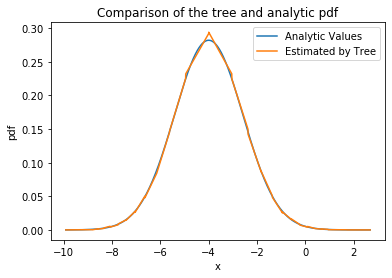

In [31]:
#
# Plotting

plt.title("Comparison of the tree and analytic pdf")
plt.xlabel("x")
plt.ylabel("pdf")

plt.plot(xCoord[argXCoord], aPDF_slice[argXCoord], label="Analytic Values")
plt.plot(xCoord[argXCoord], tPDF_slice[argXCoord], label="Estimated by Tree")

plt.legend()
plt.show()

## A Not so Trivial Second Example
Here we will present a second example.
This time it is also a Gauss distribution, but a different one.
It is known as ``Kind -22``.
$$
    \vec{\mu} = 
        \begin{pmatrix} 
            0.5 \\ -0.5
        \end{pmatrix}
    %
    \qquad
    %
    \Sigma = 
        \begin{pmatrix}
           4     & -2.28   \\
           -2.28 &  1.14
        \end{pmatrix}
$$

By simple but tedious computation we can find
$$
\left.\Sigma\right\vert_{x_1 = 0.5} =
				\begin{pmatrix}
						0		&	0		\\
						0		&	0.1404
				\end{pmatrix}
				%
				\qquad\qquad
				%
				\left.\Sigma\right\vert_{x_2 = -0.5} =
					\begin{pmatrix}
						0.39	&	0		\\
						0		&	0
					\end{pmatrix}
                %
				\qquad\qquad
				% 
                \left.\Sigma\right\vert_{x_1 = 0} =
                \begin{pmatrix}
                    0.221625	&	0		\\
					0			&	0
				\end{pmatrix}
$$

We will now verify them.

### Generate the Distribution and Samples 
First we will generate the samples and that we use for the fitting.

In [32]:
#
# Generate the distribution
dist_gaussKm22 = pyR.canDistribution(pyR.eDistiType.Gauss, -22)

In [33]:
#
# Generate the samples
sampleFit_gaussKm22 = dist_gaussKm22.generateSamplesCollection(geni, aLargeNumber)

In [34]:
#
# Show the accuracy of the fitting
statSampleFit_gaussKm22 = pyR.estMeanCovar(sampleFit_gaussKm22)

print("Theoretical mean: {}".format(dist_gaussKm22.getMean()))
print("Empirical mean:   {}".format(statSampleFit_gaussKm22[0]))

print("")
print("Theoretical covariance:")
print(dist_gaussKm22.getCoVar())

print("")
print("Empirical covariance:")
print(statSampleFit_gaussKm22[1])

Theoretical mean: [ 0.5 -0.5]
Empirical mean:   [ 0.49840099 -0.49893978]

Theoretical covariance:
[[ 4.   -2.28]
 [-2.28  1.44]]

Empirical covariance:
[[ 3.99830917 -2.27881631]
 [-2.27881631  1.43942879]]


### Generate a Tree
We will now generate a tree.
This tile we will use the constant model.

In [35]:
#
# Builder
builder_gaussKm22 = pyY.TreeBuilder(pyY.eParModel.ConstModel
                ).setGOFLevel(0.0005        # A lower level as we have before
                ).setIndepLevel(0.0005
                ).useMedianSplitter()

In [36]:
#
# Fitt the tree
tree_gaussKm22 = pyY.DETree(sampleFit_gaussKm22, dist_gaussKm22.getSampleDomain(), builder_gaussKm22)

### Helper Function
This is a small helper function that is used to make the stuff that we allways have to do for the verification.

In [37]:
def judgeBootstrap(treeSampler, targCoVar, testSize = aLargeNumber):
    
    # Generate many samples for a statistic
    bootSamples = treeSampler.generateSamplesArray(geni, testSize * 10)
    
    # Estimate statistic
    statBootSamples = pyR.estMeanCovar(bootSamples)
    
    # Print out the statistic
    print("Estimated mean: {}".format(statBootSamples[0]))
    
    print()
    print("Target covariance:")
    print(targCoVar)
    
    print()
    print("Estimated covariance:")
    print(statBootSamples[1])
    
    # Compute the differences between them
    diffInCoVar = np.linalg.norm(statBootSamples[1] - targCoVar) / np.linalg.norm(targCoVar)
    
    print("The relative difference between the target covariance and the estimated covariance is {}".format(diffInCoVar))
# end: jusge Bootstarp
    

### Unconditional Sampling
Before we go we will again perform unconditional sampling.

#### Generate a Tree Sampler

In [38]:
#
# We now generate a sampler
treeSamplerUnCond_gaussKm22 = pyR.TreeSampler(tree_gaussKm22)

#### Estimate the Quality

We now estimate the quality of our sampler.
For that we use the function we have defined above.

In [39]:
judgeBootstrap(treeSamplerUnCond_gaussKm22, statSampleFit_gaussKm22[1])

Estimated mean: [ 0.4972111  -0.49834939]

Target covariance:
[[ 3.99830917 -2.27881631]
 [-2.27881631  1.43942879]]

Estimated covariance:
[[ 4.00857582 -2.27703553]
 [-2.27703553  1.44392765]]
The relative difference between the target covariance and the estimated covariance is 0.002154097938834899


### Conditioned Sampling I
In a first test we will impose the condition that the first component has value $0.5$.
As we have presented above, the covariance matrix is then given by
$$
\left.\Sigma\right\vert_{x_1 = 0.5} =
				\begin{pmatrix}
						0		&	0		\\
						0		&	0.1404
				\end{pmatrix}
$$




#### Generate the Sampler
We will first generate the samper.
As it was already showed, we do not need to generate a condition object first, since the constructor of the tree sampler incooperate them.
However it is a bit nicer and cleaner to first create a condition object.

In [40]:
treeSamplerCondD1_gaussKm22 = pyR.TreeSampler(
            tree_gaussKm22,
            [pyR.SingleCondition(0, dist_gaussKm22.getMean()[0])])

#### Estimate the Quality of the Samples

We now estimate the quality of our sampler.
For that we use the function we have defined above.

In [41]:
judgeBootstrap(
    treeSamplerCondD1_gaussKm22, 
    np.matrix([[0, 0,], [0, 0.1404]])
)
    

Estimated mean: [ 0.5        -0.55065215]

Target covariance:
[[0.     0.    ]
 [0.     0.1404]]

Estimated covariance:
[[0.         0.        ]
 [0.         0.15249685]]
The relative difference between the target covariance and the estimated covariance is 0.08615987776413332


#### Estimate the Quality of the PDF
We will to the same as we have done before.
We will plot them.

In [42]:
#
# Creating an anaytical distribution that maps this
gaussKm22_condD1_mean  = np.matrix([-0.5])
gaussKm22_condD1_sigma = np.matrix([[0.1404]])

# Generate the distribution
gaussKm22_condD1_dist = pyR.Gauss(
    gaussKm22_condD1_mean,
    gaussKm22_condD1_sigma,
    pyY.HyperCube(1, dist_gaussKm22.getSampleDomain()[1]))

In [43]:
#
# Now we compute the analytical pdf values of of the generated samples

# We must first generate some samples
bootCondSamples_gaussKm22, bootCondSamples_gaussKm22_pdf = treeSamplerCondD1_gaussKm22.generateSamplesArrayPDF(geni, selSamples)

# Get the first dimension of the samples
bootCondSamples_gaussKm22_secDim = bootCondSamples_gaussKm22.getDimensionArray(1)

# Load it into a new sample container, we have to set that te sampels lies on a row
bootCondSamples_gaussKm22_secDim_container = pyY.SampleArray(
    bootCondSamples_gaussKm22_secDim, 
    pyY.eMatrixViewSample.Row)

# Now we have to compute the analytical PDF values
bootCondSamples_gaussKm22_apdf = gaussKm22_condD1_dist.pdf(bootCondSamples_gaussKm22_secDim_container)


In [44]:
#
# We must sort the data

# Get the xcoordinates
xCoord = bootCondSamples_gaussKm22_secDim

# Since they are unordered, we have to sort them
argXCoord = np.argsort(xCoord)

# Reorder the argument so that they are nice for plotting
aPDF_slice = bootCondSamples_gaussKm22_apdf[argXCoord]
tPDF_slice = bootCondSamples_gaussKm22_pdf[argXCoord]
xCoord = xCoord[argXCoord]



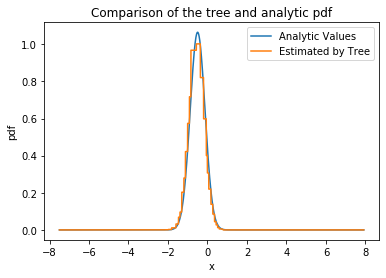

In [45]:
plt.title("Comparison of the tree and analytic pdf")
plt.xlabel("x")
plt.ylabel("pdf")

plt.plot(xCoord, aPDF_slice, label="Analytic Values")
plt.plot(xCoord, tPDF_slice, label="Estimated by Tree")

plt.legend()
plt.show()

### Conditioned Sampling II
In a first test we will impose the condition that the second component has value $-0.5$.
As we have presented above, the covariance matrix is then given by
$$
\left.\Sigma\right\vert_{x_1 = -0.5} =
				\begin{pmatrix}
						0.39	&	0		\\
						0		&	0
				\end{pmatrix}
$$


#### Generate the sampler
We will now generate a sampler object.
This time we will use a map.

In [46]:
#
# Generate a dictory
condiMat = dict()

# Make the condition
condiMat[1] = -0.5

# Generate the condition
condD2_gaussKm22 = pyR.MultiCondition(2, condiMat)

In [47]:
#
# Generate the sampler object
treeSamplerCondD2_gaussKm22 = pyR.TreeSampler(
    tree_gaussKm22,
    condD2_gaussKm22)

#### Estimate the Quality

We now estimate the quality of our sampler.
For that we use the function we have defined above.

In [48]:
judgeBootstrap(
    treeSamplerCondD2_gaussKm22, 
    np.matrix([[0.39, 0,], [0, 0]])
)
    

Estimated mean: [ 0.54208673 -0.5       ]

Target covariance:
[[0.39 0.  ]
 [0.   0.  ]]

Estimated covariance:
[[0.39256185 0.        ]
 [0.         0.        ]]
The relative difference between the target covariance and the estimated covariance is 0.0065688391188975445


## A Even Less Trivial Example

In this section we will use a 3 dimensional Gaussian for the testing.
This one also comes from the canonical distributions, it is presented in the paper of the random generator.
$$
\Sigma =
        \begin{pmatrix}
            0.35	& 0.25 	& 0.5 	\\
            0.25	& 0.4	& 0.6	\\
            0.5		& 0.6	& 1
        \end{pmatrix}
$$

### Generate the Distribution and the Samples
Here we will now generate the distributions and the samples we use for the fitting.
Since we have more dimensions, we will use even more samples for the fitting.

In [49]:
#
# Generate the distribution
dist_gaussK3 = pyR.canDistribution(pyR.eDistiType.Gauss, 3)

In [50]:
#
# We need more samples
anEvenLargerNumber = 3 * aLargeNumber

In [51]:
#
# Generate the samples
sampleFit_gaussK3 = dist_gaussK3.generateSamplesCollection(geni, anEvenLargerNumber)

In [52]:
#
# Show the accuracy of the fitting
statSampleFit_gaussK3 = pyR.estMeanCovar(sampleFit_gaussK3)

print("Theoretical mean: {}".format(dist_gaussK3.getMean()))
print("Empirical mean:   {}".format(statSampleFit_gaussK3[0]))

print("")
print("Theoretical covariance:")
print(dist_gaussK3.getCoVar())

print("")
print("Empirical covariance:")
print(statSampleFit_gaussK3[1])

Theoretical mean: [0. 0. 0.]
Empirical mean:   [-2.70627426e-05  3.03802691e-04  3.80204849e-04]

Theoretical covariance:
[[0.35 0.25 0.5 ]
 [0.25 0.4  0.6 ]
 [0.5  0.6  1.  ]]

Empirical covariance:
[[0.34945451 0.24980383 0.49946681]
 [0.24980383 0.40000709 0.59990733]
 [0.49946681 0.59990733 0.99959274]]


### Generate a Tree
We will use a linear model for the tree.

In [53]:
# 
# Builder
builder_gaussK3 = pyY.TreeBuilder(pyY.eParModel.LinModel
                ).setGOFLevel(0.0005    
                ).setIndepLevel(0.0005
                ).useMedianSplitter()

In [54]:
#
# Now we will fitt the tree
tree_gaussK3 = pyY.DETree(sampleFit_gaussK3, dist_gaussK3.getSampleDomain(), builder_gaussK3)

### Unconditional Sampling
We will now generate an unconditional tree sampler and test its accuracy


#### Generate the Tree Sampler

In [55]:
#
# We now generate a sampler
treeSamplerUnCond_gaussK3 = pyR.TreeSampler(tree_gaussK3)

#### Estimate the Quality
We will now look at the quality fo the sampler.
For that we will again use the helper function from before.
As a target covariance we use the one that we have estimated from samples to fit.

In [56]:
#
# Estimate the tests
judgeBootstrap(
    treeSamplerUnCond_gaussK3, 
    statSampleFit_gaussK3[1],
    anEvenLargerNumber * 5
)

Estimated mean: [-3.55993040e-05  3.46624163e-04  4.42159614e-04]

Target covariance:
[[0.34945451 0.24980383 0.49946681]
 [0.24980383 0.40000709 0.59990733]
 [0.49946681 0.59990733 0.99959274]]

Estimated covariance:
[[0.37784321 0.25108683 0.50420815]
 [0.25108683 0.42382301 0.60590044]
 [0.50420815 0.60590044 1.02693   ]]
The relative difference between the target covariance and the estimated covariance is 0.029216296336940773


### Conditional Sampling I
Now we will prescribe the value of the second dimension, note again, this means index 1, since we use zero based indexing.

By straight forward but tedious calculation we get
$$
\left.\Sigma\right\vert_{x_2 = 0} =
        \begin{pmatrix}
            0.19375		& 0 	& 0.125	\\
            0			& 0		& 0		\\
            0.125		& 0		& 0.1
        \end{pmatrix}
$$

#### Generate a Sampler
Now we generate a sampler.

In [57]:
treeSamplerCondD2_gaussK3 = pyR.TreeSampler(
            tree_gaussK3,
            [pyR.SingleCondition(1, dist_gaussK3.getMean()[1])])

#### Estimate the Quality
We will again test the quality.
As target we use the theoretical value.

In [58]:
judgeBootstrap(
    treeSamplerCondD2_gaussK3, 
    np.matrix([[0.19375, 0, 0.125], [0, 0, 0], [0.125, 0, 0.1]]),
    anEvenLargerNumber * 5
)

Estimated mean: [0.00061534 0.         0.00082005]

Target covariance:
[[0.19375 0.      0.125  ]
 [0.      0.      0.     ]
 [0.125   0.      0.1    ]]

Estimated covariance:
[[0.22466792 0.         0.12967177]
 [0.         0.         0.        ]
 [0.12967177 0.         0.11535622]]
The relative difference between the target covariance and the estimated covariance is 0.12521828064073165


### Conditional Sampling II
We will now also prescribe the thrid dimension to $0$.

By straight forward but tedious calculation we get
$$
\left.\Sigma\right\vert_{x_2 = 0, x_3 = 0} =
        \begin{pmatrix}
            0.0375		& 0 	& 0  	\\
            0			& 0		& 0		\\
            0    		& 0		& 0
        \end{pmatrix}
$$


#### Generate a Sampler
Now we will generate a sampler.


In [59]:
treeSamplerCondD2D3_gaussK3 = pyR.TreeSampler(
            tree_gaussK3,
            [pyR.SingleCondition(1, dist_gaussK3.getMean()[1]),
             pyR.SingleCondition(2, dist_gaussK3.getMean()[2])]
)

#### Estimate the Quality
Now we will estimate the quality.

In [60]:
judgeBootstrap(
    treeSamplerCondD2D3_gaussK3, 
    np.matrix([[0.0375, 0, 0], [0, 0, 0], [0, 0, 0]]),
    anEvenLargerNumber * 5
)

Estimated mean: [-0.01672499  0.          0.        ]

Target covariance:
[[0.0375 0.     0.    ]
 [0.     0.     0.    ]
 [0.     0.     0.    ]]

Estimated covariance:
[[0.03765398 0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
The relative difference between the target covariance and the estimated covariance is 0.0041061474439344865


#### Estimate the PDF
Here we will now plot the pdf value of the restricted version.

In [61]:
#
# Creating an anaytical distribution that maps this
gaussK3_condD2u3_mean  = np.matrix([0.0])
gaussK3_condD2u3_sigma = np.matrix([[0.0375]])

# Generate the distribution
gaussK3_condD2u3_dist = pyR.Gauss(
    gaussK3_condD2u3_mean,
    gaussK3_condD2u3_sigma,
    pyY.HyperCube(1, dist_gaussK3.getSampleDomain()[0]))

In [62]:
#
# Now we compute the analytical pdf values of of the generated samples

# We increase the number of samples we use
selSamples = selSamples * 3


# We must first generate some samples
bootCondSamplesD2u3_gaussK3, bootCondSamplesD2u3_gaussK3_pdf = treeSamplerCondD2D3_gaussK3.generateSamplesArrayPDF(geni, selSamples)

# Get the first dimension of the samples
bootCondSamplesD2u3_gaussK3_firstDim = bootCondSamplesD2u3_gaussK3.getDimensionArray(0)

# Load it into a new sample container, we have to set that te sampels lies on a row
bootCondSamplesD2u3_gaussK3_firstDim_container = pyY.SampleArray(
    bootCondSamplesD2u3_gaussK3_firstDim, 
    pyY.eMatrixViewSample.Row)

# Now we have to compute the analytical PDF values
bootCondSamples_gaussKm22_apdf = gaussK3_condD2u3_dist.pdf(bootCondSamplesD2u3_gaussK3_firstDim_container)

In [63]:
#
# We must sort the data

# Get the xcoordinates
xCoord = bootCondSamplesD2u3_gaussK3_firstDim

# Since they are unordered, we have to sort them
argXCoord = np.argsort(xCoord)

# Reorder the argument so that they are nice for plotting
aPDF_slice = bootCondSamples_gaussKm22_apdf[argXCoord]
tPDF_slice = bootCondSamplesD2u3_gaussK3_pdf[argXCoord]
xCoord = xCoord[argXCoord]


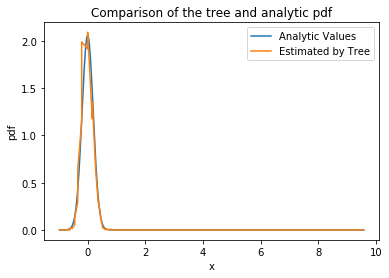

In [64]:
plt.title("Comparison of the tree and analytic pdf")
plt.xlabel("x")
plt.ylabel("pdf")

plt.plot(xCoord, aPDF_slice, label="Analytic Values")
plt.plot(xCoord, tPDF_slice, label="Estimated by Tree")

plt.legend()
plt.show()